<table align="left">
  <td>
    <a href="https://is.gd/BUV5Wc" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Applied Machine Learning Techniques to Breast Cancer Recurrence Classification


## Data Science Project - 4 Classes Tune
ELE2345

Diego R. Páez Ardila - 2120653

20/05/2022

<a href="https://ibb.co/Bw43dyX"><img src="https://i.ibb.co/9GwgzbF/Metodolog-a-3.jpg" alt="Metodolog-a-3"  width="400" border="2"></a>

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
mpl.rc('axes', labelsize=16)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# to make this notebook's output stable across runs
np.random.seed(42)

from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,classification_report,cohen_kappa_score, accuracy_score  
from sklearn.metrics import roc_curve, roc_auc_score, f1_score,precision_score,recall_score  
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from collections import Counter

from sklearn.decomposition import PCA

# 1- General Pre-Processing (GPP)

The dataset is studied to identify missing data, analyze the correlation between the attributes and the target class, observe if there is an imbalance in the target class and identify if it is necessary to apply regularization to the data.

In [5]:
df_4classes = pd.read_excel('/content/drive/MyDrive/data/dadoscancer_4classes.xlsx')
df_4classes.head()

,Cancer Type Detailed,Subtype,Diagnosis Age,Sex,Ethnicity Category,Race Category,Neoplasm Cancer Code,Aneuploidy Score,Buffa Hypoxia Score,Ragnum Hypoxia Score,Winter Hypoxia Score,Fraction Genome Altered,In PanCan Pathway Analysis,Mutation Count,Post Initial Therapy,Prior Diagnosis,Radiation Therapy,Tissue Prospective Indicator,Class
0,2,2,55,0,1,2,11,19,-21,0,-28,0.7787,1,24,0,0,0,0,1
1,1,1,50,0,1,1,5,22,5,18,20,0.7164,1,458,0,0,1,0,3
2,0,0,54,0,1,0,4,16,27,14,22,0.4163,1,62,1,0,1,0,1
3,1,2,66,0,0,2,1,3,-27,-8,-20,0.0862,1,41,0,0,1,0,3
4,1,0,36,0,1,1,9,9,17,12,4,0.6407,1,128,1,0,1,0,0


In [6]:
counter = Counter(df_4classes["Sex"])
print(counter)
print('%s : %d' % ('Women', counter[0]))
print('%s : %d' % ('Men', counter[1]))

#Smote
idx_0 = np.where(df_4classes.Sex == 0)
idx_1 = np.where(df_4classes.Sex == 1)

Counter({0: 340, 1: 4})
Women : 340
Men : 4


In [7]:
df_sexOut = df_4classes.drop(["Sex"], axis=1)

## Target Class Analysis

It was identified that the distribution of data in the target class is unbalanced.

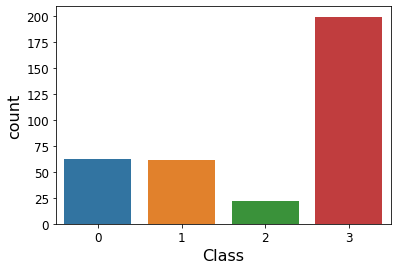

In [8]:
sns.countplot(x=df_sexOut.Class)

In [9]:
# Generate and plot a synthetic imbalanced classification dataset
counter = Counter(df_sexOut["Class"])
print('%s : %d' % ('No Recurrence', counter[0]))
print('%s : %d' % ('Early Recurrence', counter[1]))
print('%s : %d' % ('Middle Recurrence', counter[2]))
print('%s : %d' % ('Late Recurrence', counter[3]))

No Recurrence : 62
Early Recurrence : 61
Middle Recurrence : 22
Late Recurrence : 199


## K-Means

The third class has a low number of instances, therefore the K-Means clutering algorithm is used to reduce the classes to 3.

In [10]:
from sklearn.cluster import KMeans

Target = np.array(df_sexOut["Class"])
km = KMeans(n_clusters=3, init='random',n_init=10, max_iter=300,tol=1e-04, random_state=1)
Target_knn = km.fit_predict(Target.reshape(-1, 1))
Target_knn = pd.DataFrame(Target_knn, columns = ["Target"])

df_knn=pd.concat([df_sexOut.drop(["Class"],axis=1), Target_knn], axis = 1)

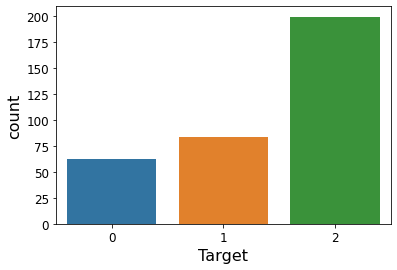

In [11]:
sns.countplot(df_knn["Target"])

In [12]:
counter = Counter(df_knn["Target"])
print('%s : %d' % ('No Recurrence', counter[0]))
print('%s : %d' % ('Early Recurrence', counter[1]))
print('%s : %d' % ('Late Recurrence', counter[2]))

No Recurrence : 62
Early Recurrence : 83
Late Recurrence : 199


## Data Transformation

Handle discrete and continuous inputs together:

- Rescale bounded continuous features: All continuous input that are bounded, rescale them to [-1, 1] through $x = \frac{(2x - max - min)}{(max - min)}$.

- Standardize all continuous features: All continuous input should be standardized and by this I mean, for every continuous feature, compute its mean (u) and standard deviation (s) and do $x = \frac{(x - u)}{s}$.

- Binarize categorical/discrete features: For all categorical features, represent them as multiple boolean features. For example, instead of having one feature called marriage_status, have 3 boolean features - married_status_single, married_status_married, married_status_divorced and appropriately set these features to 1 or -1. As you can see, for every categorical feature, you are adding k binary feature where k is the number of values that the categorical feature takes.

[Reference](https://www.quora.com/Machine-Learning/What-are-good-ways-to-handle-discrete-and-continuous-inputs-together/answer/Arun-Iyer-1)

In [13]:
df_categorical = df_knn.drop(["Diagnosis Age","Aneuploidy Score","Buffa Hypoxia Score","Ragnum Hypoxia Score","Winter Hypoxia Score","Fraction Genome Altered", "Mutation Count"], axis=1)
df_continuous  = df_knn.drop(df_categorical.columns,axis=1)
df_categorical = df_categorical.drop("Target", axis=1)
df_categorical.head()

,Cancer Type Detailed,Subtype,Ethnicity Category,Race Category,Neoplasm Cancer Code,In PanCan Pathway Analysis,Post Initial Therapy,Prior Diagnosis,Radiation Therapy,Tissue Prospective Indicator
0,2,2,1,2,11,1,0,0,0,0
1,1,1,1,1,5,1,0,0,1,0
2,0,0,1,0,4,1,1,0,1,0
3,1,2,0,2,1,1,0,0,1,0
4,1,0,1,1,9,1,1,0,1,0


## Encode categorical integer features using a one-hot.
  - - Cancer Type Detailed
  - - Subtype
  - - Race Category
  - - Neoplasm Cancer Code

2. The input to this transformer should be a matrix of integers, denoting the values taken on by categorical (discrete) features.

3. The output will be a sparse matrix where each column corresponds to one possible value of one feature.

In [14]:
df_categorical_int= df_categorical[['Cancer Type Detailed','Subtype',"Race Category",'Neoplasm Cancer Code']]
df_categorical_int.head()

,Cancer Type Detailed,Subtype,Race Category,Neoplasm Cancer Code
0,2,2,2,11
1,1,1,1,5
2,0,0,0,4
3,1,2,2,1
4,1,0,1,9


In [15]:
# TODO: create a OneHotEncoder object, and fit it to all of X
# Ref: https://www.statology.org/one-hot-encoding-in-python/
# 1. INSTANTIATE
encoder = preprocessing.OneHotEncoder()

# 2. FIT
encoder.fit(df_categorical_int)

# 3. Transform
df_cat_int_onehot = pd.DataFrame(encoder.transform(df_categorical_int).toarray())

#merge one-hot encoded columns back with original DataFrame
df_1hot = df_categorical.join(df_cat_int_onehot)
df_categorical_1hot = df_1hot.drop(['Cancer Type Detailed','Subtype',"Race Category",'Neoplasm Cancer Code'], axis=1)
df_categorical_1hot.head()

,Ethnicity Category,In PanCan Pathway Analysis,Post Initial Therapy,Prior Diagnosis,Radiation Therapy,Tissue Prospective Indicator,0,1,2,3,...,15,16,17,18,19,20,21,22,23,24
0,1,1,0,0,0,0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,1,0,0,1,0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1,1,0,1,0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1,0,0,1,0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1,1,0,1,0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Standardize all continuous features

In [16]:
df_scaled = preprocessing.scale(df_continuous)
df_continuous = pd.DataFrame(df_scaled, columns=df_continuous.columns)
df_continuous.head()

,Diagnosis Age,Aneuploidy Score,Buffa Hypoxia Score,Ragnum Hypoxia Score,Winter Hypoxia Score,Fraction Genome Altered,Mutation Count
0,-0.108690,0.911473,-0.521661,-0.238922,-0.787674,2.307478,-0.208074
1,-0.476698,1.312941,0.703906,1.266068,1.525751,2.011554,1.578998
2,-0.182292,0.510005,1.740924,0.931626,1.622143,0.586084,-0.051603
3,0.700925,-1.229691,-0.804484,-0.907807,-0.402103,-0.981885,-0.138074
4,-1.507117,-0.426755,1.269552,0.764405,0.754609,1.651981,0.220164


## Dataset GPP

Standardized continuous data are merged with categorical data after onehot is applied. 

In [17]:
df_GPP = df_continuous.join(df_categorical_1hot)
df_GPP.head()

,Diagnosis Age,Aneuploidy Score,Buffa Hypoxia Score,Ragnum Hypoxia Score,Winter Hypoxia Score,Fraction Genome Altered,Mutation Count,Ethnicity Category,In PanCan Pathway Analysis,Post Initial Therapy,...,15,16,17,18,19,20,21,22,23,24
0,-0.108690,0.911473,-0.521661,-0.238922,-0.787674,2.307478,-0.208074,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.476698,1.312941,0.703906,1.266068,1.525751,2.011554,1.578998,1,1,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.182292,0.510005,1.740924,0.931626,1.622143,0.586084,-0.051603,1,1,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.700925,-1.229691,-0.804484,-0.907807,-0.402103,-0.981885,-0.138074,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.507117,-0.426755,1.269552,0.764405,0.754609,1.651981,0.220164,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# 2-Model Configuration


## Model Performance **Function**



- Confusion Matrix:
- Classification Report:
- Cohen Kappa Score:
- AUROC Score: 

In [18]:
def performanceCal(ytest, ypredict,yprob):
  """
    Calculation of performance metrics:
    - Confusion Matrix:
    - Accuracy Score: https://is.gd/YwoQJf
    - Precision Score: https://is.gd/Xz6Nu0
    - F1-Score: https://is.gd/YVGWCs
    - Recall Score: https://is.gd/9PUCgT 
    - Cohen Kappa Score:
    - AUROC Score: https://is.gd/JIAktb
    Arguments:
        ytest: ndarray - list
        ypredict: ndarray - list
        ypredict_probability
    Returns:
        List with result of performance metrics: matrixconfu,accuracyscore,
        precisionscore,f1score,recallscore,cohenkappa,auroc_score
    """

  matrixconfu = confusion_matrix(ytest, ypredict)
  matrixreport = classification_report(ytest, ypredict)
  accuracyscore = round(accuracy_score(ytest, ypredict),3)
  f1score = round(f1_score(ytest, ypredict, average='weighted'),3)
  precisionscore = round(precision_score(ytest, ypredict, average='weighted'),3)
  recallscore = round(recall_score(ytest, ypredict, average='weighted'),3)
  

  cohenkappa= round(cohen_kappa_score(ytest, ypredict),3)
  auroc_score = round(roc_auc_score(ytest, yprob,multi_class="ovr"),3)


  result = [matrixconfu,matrixreport,accuracyscore,precisionscore,f1score,recallscore,cohenkappa,auroc_score]
  return result


## Model Classifiers **Function**
Function for the application of the models in a systematic way.

In [19]:
def modelClas(model,x,y,xtrain,ytrain,xtest):
  """
  Model Evaluation:

  Arguments:
      model: sklearn classifier model
      X_: ndarray - list
      y_: ndarray - list
      xtrain: ndarray - list
      ytrain: ndarray - list
      xtest: ndarray - list
  Returns:
      List with result accuracy kfold and model predictions
  """
  cv = KFold(n_splits=10, random_state=1, shuffle=True)
  scores_origin = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1)
  
  accuracy_kfold = round(mean(scores_origin),3)
  std_kfold = round(std(scores_origin),3)
  model.fit(xtrain, ytrain)
  model_predic = model.predict(xtest)
  pred_prob = model.predict_proba(xtest)

  # ['accuracy', 'average_precision', 'f1','recall', 'roc_auc']

  return [accuracy_kfold,std_kfold, model_predic,pred_prob]

In [20]:
def heatmapgraph(data):
  ax = sns.heatmap(data, annot=True,xticklabels=['No Recurrence','Early Recurrence','Late Recurrence'],
                 yticklabels=['No Recurrence','Early Recurrence','Late Recurrence'],cbar=False, cmap='Blues')
  ax.set_xlabel("Prediction")
  ax.set_ylabel("Actual")

## MC- 1

**MC-1 (Training)**: Training of Logistic Regression (LR), Naive Bayes (NB), Support Vector Machine (SVM), k nearest neighbors (KNN) models using the original dataset.

Calculation of performance metrics using the original dataset, to have an initial reference point. 

In [21]:
X_origin = df_knn.drop(["Target"],axis=1)
y_origin = df_knn["Target"]
X_train, X_test, y_train, y_test = train_test_split(X_origin, y_origin, test_size=0.2, random_state=1)

modelLR_MC1 = LogisticRegression(C=2.154434690031882,penalty='l2', solver='liblinear',random_state=1)
modelNB_MC1 = GaussianNB(var_smoothing=8.126619200091945e-07)
modelSVC_MC1 = SVC(C=1, gamma=1, kernel='linear',probability=True,random_state=1)
modelKNN_MC1 = KNeighborsClassifier(leaf_size=1, n_neighbors=22, p=1)

models_MC1=[modelLR_MC1,modelNB_MC1,modelSVC_MC1,modelKNN_MC1]
#plt.subplots(2,2,figsize=(15,15))
modelsNames = ["Logistic Regression", "Naive Bayes", "SVM", "KNN"]
metricsResults = []

for idx, model in enumerate(models_MC1):
  modelResults = modelClas(model,X_origin,y_origin,X_train,y_train,X_test)
  metrics = performanceCal(y_test,modelResults[2],modelResults[3])
  metrics.insert(2,modelsNames[idx])
  metrics.insert(3,modelResults[0])
  metrics.insert(4,modelResults[1])
  metricsResults.append(metrics[2:])

  print('Conf Matrix and Class report ' + modelsNames[idx] + ": \n"  ,metrics[0])
  print(metrics[1])

Conf Matrix and Class report Logistic Regression: 
 [[ 5  6  0]
 [ 0 12  1]
 [ 0  0 45]]
              precision    recall  f1-score   support

           0       1.00      0.45      0.62        11
           1       0.67      0.92      0.77        13
           2       0.98      1.00      0.99        45

    accuracy                           0.90        69
   macro avg       0.88      0.79      0.80        69
weighted avg       0.92      0.90      0.89        69

Conf Matrix and Class report Naive Bayes: 
 [[ 3  8  0]
 [ 0 12  1]
 [ 1  0 44]]
              precision    recall  f1-score   support

           0       0.75      0.27      0.40        11
           1       0.60      0.92      0.73        13
           2       0.98      0.98      0.98        45

    accuracy                           0.86        69
   macro avg       0.78      0.72      0.70        69
weighted avg       0.87      0.86      0.84        69

Conf Matrix and Class report SVM: 
 [[ 5  6  0]
 [ 1 11  1]
 [ 0  0 

In [22]:
#create data
data = [metricsResults[0],metricsResults[1],metricsResults[2],metricsResults[3]]
  
#define header names
col_names = ["Models", "Accuracy CV","STD CV", "Accuracy", "Precision","Recall", "F1-Score", "Cohen Kappa Score", "AUC ROC Score"]
  
#display table
MC1_Results = pd.DataFrame(data=data, columns=col_names)
MC1_Results

,Models,Accuracy CV,STD CV,Accuracy,Precision,Recall,F1-Score,Cohen Kappa Score,AUC ROC Score
0,Logistic Regression,0.837,0.050,0.899,0.923,0.891,0.899,0.799,0.935
1,Naive Bayes,0.793,0.052,0.855,0.870,0.838,0.855,0.716,0.938
2,SVM,0.831,0.059,0.884,0.893,0.877,0.884,0.770,0.955
3,KNN,0.575,0.082,0.652,0.521,0.546,0.652,0.074,0.627


## General Split Train Test Dataset

In [23]:
# Split data 80-20 %
X = df_GPP
y = df_knn["Target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print(np.shape(X_train))
print(np.shape(y_train))

print(np.shape(X_test))
print(np.shape(y_test))

(275, 38)
(275,)
(69, 38)
(69,)


## MC-2

In [24]:
modelLR_MC2 = LogisticRegression(C= 1.0, penalty= 'l1', solver='saga',random_state=1)
modelNB_MC2 = GaussianNB(var_smoothing=0.03851107002325571)
modelSVC_MC2 = SVC(C=1, gamma=1, kernel='linear',probability=True,random_state=1)
modelKNN_MC2 = KNeighborsClassifier(leaf_size= 1,p= 1, n_neighbors= 10)

models_MC2=[modelLR_MC2,modelNB_MC2,modelSVC_MC2,modelKNN_MC2]
#plt.subplots(2,2,figsize=(15,15))
modelsNames = ["Logistic Regression", "Naive Bayes", "SVM", "KNN"]
metricsResults = []

for idx, model in enumerate(models_MC2):
  modelResults = modelClas(model,X,y,X_train,y_train,X_test)
  metrics = performanceCal(y_test,modelResults[2],modelResults[3])
  metrics.insert(2,modelsNames[idx])
  metrics.insert(3,modelResults[0])
  metrics.insert(4,modelResults[1])
  metricsResults.append(metrics[2:])

  print('Conf Matrix and Class report ' + modelsNames[idx] + ": \n"  ,metrics[0])
  print(metrics[1])

Conf Matrix and Class report Logistic Regression: 
 [[ 5  6  0]
 [ 0 12  1]
 [ 0  0 45]]
              precision    recall  f1-score   support

           0       1.00      0.45      0.62        11
           1       0.67      0.92      0.77        13
           2       0.98      1.00      0.99        45

    accuracy                           0.90        69
   macro avg       0.88      0.79      0.80        69
weighted avg       0.92      0.90      0.89        69

Conf Matrix and Class report Naive Bayes: 
 [[ 5  5  1]
 [ 1 11  1]
 [ 1  1 43]]
              precision    recall  f1-score   support

           0       0.71      0.45      0.56        11
           1       0.65      0.85      0.73        13
           2       0.96      0.96      0.96        45

    accuracy                           0.86        69
   macro avg       0.77      0.75      0.75        69
weighted avg       0.86      0.86      0.85        69

Conf Matrix and Class report SVM: 
 [[ 5  5  1]
 [ 2 10  1]
 [ 0  0 

In [25]:
#create data
data = [metricsResults[0],metricsResults[1],metricsResults[2],metricsResults[3]]
  
#define header names
col_names = ["Models", "Accuracy CV","STD CV", "Accuracy", "Precision","Recall", "F1-Score", "Cohen Kappa Score", "AUC ROC Score"]
  
#display table
MC2_Results = pd.DataFrame(data=data, columns=col_names)
MC2_Results

,Models,Accuracy CV,STD CV,Accuracy,Precision,Recall,F1-Score,Cohen Kappa Score,AUC ROC Score
0,Logistic Regression,0.825,0.063,0.899,0.923,0.891,0.899,0.799,0.959
1,Naive Bayes,0.808,0.062,0.855,0.859,0.850,0.855,0.717,0.920
2,SVM,0.837,0.058,0.870,0.864,0.861,0.870,0.738,0.948
3,KNN,0.703,0.081,0.667,0.556,0.606,0.667,0.246,0.791


## MC-3

A feature selection techniques (PCA) is applied to the GPP dataset to select the most significant attributes for the target class in the dataset. 


**MCP-3 (Training + GPP + Feature Extraction)**: Training of Logistic Regression (LR), Naive Bayes (NB), Support Vector Machine (SVM), k nearest neighbors (KNN) models using the dataset with GPP + Feature Extraction.

In [26]:
# Make an instance of the Model
pca = PCA(.95)

In [27]:
pca.fit(X_train)

PCA(n_components=0.95)

In [28]:
pcaColumns = []
limit = pca.n_components_
for i in range (0,limit):
  name = "PCA" + str(i)
  pcaColumns.append(name)

In [29]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

X_train_pca = pd.DataFrame(data = X_train_pca, columns = pcaColumns)
X_test_pca =  pd.DataFrame(data = X_test_pca, columns = pcaColumns)
X_train_pca.head()

,PCA0,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,PCA13,PCA14,PCA15,PCA16,PCA17,PCA18
0,2.336140,-0.185195,-0.288418,0.813684,0.378214,-1.309581,-0.419655,0.227584,-0.327991,-0.684859,-0.039167,0.582865,-0.006108,-0.132619,0.071150,-0.106995,-0.368012,-0.313111,-0.115478
1,-0.638835,-0.426544,0.349164,0.846421,-0.403638,1.006611,-0.194936,-0.026324,0.318923,0.432620,0.783174,0.665122,-0.375206,0.180792,-0.360290,-0.117460,-0.309866,-0.330943,-0.076339
2,2.019905,0.382188,-1.140450,-0.661648,-0.379624,0.281515,-0.262251,-0.363293,0.541636,0.583737,0.688315,0.433853,-0.487775,0.261833,-0.300455,-0.117143,-0.077294,-0.045736,-0.158613
3,-0.716667,-0.148112,-0.044311,0.713737,0.373512,-0.741325,0.364294,-0.026643,-0.905010,-0.256450,0.279972,0.493636,1.249213,-0.605555,0.295224,-0.328248,-0.347733,-0.026616,0.878326
4,-2.240560,0.471986,-0.428633,-0.125081,0.251565,-0.896413,-0.515226,0.400978,0.143702,-0.688418,0.256889,-0.678559,-0.069631,-0.084445,0.029907,0.104594,-0.186845,-0.011975,-0.117481


In [30]:
y_train_pca = y_train
y_test_pca = y_test

print(np.shape(X_train_pca))
print(np.shape(y_train_pca))

print(np.shape(X_test_pca))
print(np.shape(y_test_pca))

(275, 19)
(275,)
(69, 19)
(69,)


In [31]:
modelLR_MC3 = LogisticRegression(C= 1.0, penalty= 'l1', solver='liblinear',random_state=1)
modelNB_MC3 = GaussianNB(var_smoothing=0.01)
modelSVC_MC3 = SVC(C=1, gamma=1, kernel='linear',probability=True,random_state=1)
modelKNN_MC3 = KNeighborsClassifier(leaf_size=1, n_neighbors=6, p=1)

models_MC3=[modelLR_MC3,modelNB_MC3,modelSVC_MC3,modelKNN_MC3]
#plt.subplots(2,2,figsize=(15,15))
modelsNames = ["Logistic Regression", "Naive Bayes", "SVM", "KNN"]
metricsResults = []

for idx, model in enumerate(models_MC3):
  modelResults = modelClas(model,X_train_pca,y_train_pca,X_train_pca,y_train_pca,X_test_pca)
  metrics = performanceCal(y_test_pca,modelResults[2],modelResults[3])
  metrics.insert(2,modelsNames[idx])
  metrics.insert(3,modelResults[0])
  metrics.insert(4,modelResults[1])
  metricsResults.append(metrics[2:])
  print('Conf Matrix and Class report ' + modelsNames[idx] + ": \n"  ,metrics[0])
  print(metrics[1])

Conf Matrix and Class report Logistic Regression: 
 [[ 3  8  0]
 [ 1 10  2]
 [ 0  1 44]]
              precision    recall  f1-score   support

           0       0.75      0.27      0.40        11
           1       0.53      0.77      0.62        13
           2       0.96      0.98      0.97        45

    accuracy                           0.83        69
   macro avg       0.74      0.67      0.66        69
weighted avg       0.84      0.83      0.81        69

Conf Matrix and Class report Naive Bayes: 
 [[ 1  7  3]
 [ 0  9  4]
 [ 1  0 44]]
              precision    recall  f1-score   support

           0       0.50      0.09      0.15        11
           1       0.56      0.69      0.62        13
           2       0.86      0.98      0.92        45

    accuracy                           0.78        69
   macro avg       0.64      0.59      0.56        69
weighted avg       0.75      0.78      0.74        69

Conf Matrix and Class report SVM: 
 [[ 4  7  0]
 [ 3  9  1]
 [ 0  0 

In [32]:
#create data
data = [metricsResults[0],metricsResults[1],metricsResults[2],metricsResults[3]]
  
#define header names
col_names = ["Models", "Accuracy CV","STD CV", "Accuracy", "Precision","Recall", "F1-Score", "Cohen Kappa Score", "AUC ROC Score"]
  
#display table
MC3_Results = pd.DataFrame(data=data, columns=col_names)
MC3_Results

,Models,Accuracy CV,STD CV,Accuracy,Precision,Recall,F1-Score,Cohen Kappa Score,AUC ROC Score
0,Logistic Regression,0.811,0.069,0.826,0.843,0.812,0.826,0.655,0.944
1,Naive Bayes,0.767,0.096,0.783,0.748,0.739,0.783,0.537,0.925
2,SVM,0.793,0.078,0.841,0.835,0.833,0.841,0.685,0.957
3,KNN,0.691,0.070,0.754,0.740,0.745,0.754,0.500,0.802


## MC-4

**MCP-4 (Training + GPP + Feature Extraction + Oversample)**: Training of Logistic Regression (LR), Naive Bayes (NB), Support Vector Machine (SVM), k nearest neighbors (KNN) models using the dataset with GPP + Feature Extraction. To avoid the problem of imbalance in the target class, the SMOTE method is used. 

In [33]:
# import library
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit predictor and target variable
x_train_smote, y_train_smote = smote.fit_resample(X_train_pca, y_train_pca)

print('Original dataset shape', Counter(y_train_pca))
print('Resample dataset shape', Counter(y_train_smote))

Original dataset shape Counter({2: 154, 1: 70, 0: 51})
Resample dataset shape Counter({1: 154, 2: 154, 0: 154})


In [34]:
modelLR_MC4 = LogisticRegression(C=1000.0, penalty='l1', solver='liblinear',random_state=1)
modelNB_MC4 = GaussianNB(var_smoothing=0.003511191734215131)
modelSVC_MC4 = SVC(C=100, gamma=0.1,probability=True,random_state=1)
modelKNN_MC4 = KNeighborsClassifier(leaf_size=1, n_neighbors=1, p=1)

models_MC4=[modelLR_MC4,modelNB_MC4,modelSVC_MC4,modelKNN_MC4]
#plt.subplots(2,2,figsize=(15,15))
modelsNames = ["Logistic Regression", "Naive Bayes", "SVM", "KNN"]
metricsResults = []

for idx, model in enumerate(models_MC4):
  modelResults = modelClas(model,X_train_pca,y_train_pca,x_train_smote,y_train_smote,X_test_pca)
  metrics = performanceCal(y_test_pca,modelResults[2],modelResults[3])
  metrics.insert(2,modelsNames[idx])
  metrics.insert(3,modelResults[0])
  metrics.insert(4,modelResults[1])
  metricsResults.append(metrics[2:])
  print('Conf Matrix and Class report ' + modelsNames[idx] + ": \n"  ,metrics[0])
  print(metrics[1])

Conf Matrix and Class report Logistic Regression: 
 [[ 5  6  0]
 [ 3 10  0]
 [ 0  1 44]]
              precision    recall  f1-score   support

           0       0.62      0.45      0.53        11
           1       0.59      0.77      0.67        13
           2       1.00      0.98      0.99        45

    accuracy                           0.86        69
   macro avg       0.74      0.73      0.73        69
weighted avg       0.86      0.86      0.85        69

Conf Matrix and Class report Naive Bayes: 
 [[ 3  7  1]
 [ 2 10  1]
 [ 2  1 42]]
              precision    recall  f1-score   support

           0       0.43      0.27      0.33        11
           1       0.56      0.77      0.65        13
           2       0.95      0.93      0.94        45

    accuracy                           0.80        69
   macro avg       0.65      0.66      0.64        69
weighted avg       0.80      0.80      0.79        69

Conf Matrix and Class report SVM: 
 [[ 3  7  1]
 [ 3  9  1]
 [ 1  2 

In [35]:
#create data
data = [metricsResults[0],metricsResults[1],metricsResults[2],metricsResults[3]]
  
#define header names
col_names = ["Models", "Accuracy CV","STD CV", "Accuracy", "Precision","Recall", "F1-Score", "Cohen Kappa Score", "AUC ROC Score"]
  
#display table
MC4_Results = pd.DataFrame(data=data, columns=col_names)
MC4_Results

,Models,Accuracy CV,STD CV,Accuracy,Precision,Recall,F1-Score,Cohen Kappa Score,AUC ROC Score
0,Logistic Regression,0.815,0.066,0.855,0.863,0.854,0.855,0.721,0.931
1,Naive Bayes,0.764,0.080,0.797,0.796,0.790,0.797,0.609,0.909
2,SVM,0.727,0.104,0.783,0.785,0.778,0.783,0.581,0.864
3,KNN,0.654,0.100,0.652,0.673,0.661,0.652,0.349,0.671


# Performance of Trained Models 

Performance comparison of the trained models with k-fold cross validation

In [36]:
mc1 = MC1_Results[["Accuracy CV","STD CV"]]
mc2 = MC2_Results[["Accuracy CV","STD CV"]]
mc3 = MC3_Results[["Accuracy CV","STD CV"]]
mc4 = MC4_Results[["Accuracy CV","STD CV"]]

headers= ["MC-1 CV","STD CV","MC-2 CV","STD CV","MC-3 CV","STD CV","MC-4 CV","STD CV"]
index = ["LR","NB","SVM","KNN"]

acc_CV = pd.concat([mc1,mc2,mc3,mc4], axis=1)
acc_CV.columns = headers
acc_CV.index = index

acc_CV

,MC-1 CV,STD CV,MC-2 CV,STD CV,MC-3 CV,STD CV,MC-4 CV,STD CV
LR,0.837,0.050,0.825,0.063,0.811,0.069,0.815,0.066
NB,0.793,0.052,0.808,0.062,0.767,0.096,0.764,0.080
SVM,0.831,0.059,0.837,0.058,0.793,0.078,0.727,0.104
KNN,0.575,0.082,0.703,0.081,0.691,0.070,0.654,0.100


In [37]:
#%%shell
#jupyter nbconvert --to html /content/Projeto_DS_4clases_Tune.ipynb